# 1. General setup

In [1]:
import torch

from snli_lightning import SNLIModule
from models import ENCODER_TYPES
from encoder import CLASSIFIER_TYPES
from data import SNLIdataset, LABEL_VALUE
from vocab import Vocab, PAD_TOKEN, UNK_TOKEN


/Users/FrankVerhoef/opt/anaconda3/envs/atcs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
LABELS = [k for k, _ in sorted(LABEL_VALUE.items(), key=lambda x: x[1])]

def predict_one(model, p, h):
    """
        p and h should be strings
    """

    p_ids = torch.tensor([vocab.encode(vocab.tokenize(p))])
    h_ids = torch.tensor([vocab.encode(vocab.tokenize(h))])

    out = model((
        (p_ids, [len(p_ids)]), 
        (h_ids, [len(h_ids)])
    ))
    pred = out.argmax(dim=-1)[0].item()

    return LABELS[pred]

In [3]:
# set params for the sentence encoder
opt = {
    "data_dir": "data/",
    "dataset_dir": "snli_1_0/",
    "dataset_file": "snli_1.0",
    "model_dir": "models/",
    "vocab_file": "snli_vocab.json",
    "embeddings_file": "glove.840B.300d.txt",
    "snli_embeddings": "glove.snli.300d.txt",
    "embedding_size": 300,
    "hidden_size": 2048,
    "num_layers": 64,
    "batch_size": 64,
    "aggregate_method": "max",
    "classifier": "mlp"
}

print('Parameters')
print('\n'.join(["{:20}\t{}".format(k,v) for k,v in opt.items()]))


Parameters
data_dir            	data/
dataset_dir         	snli_1_0/
dataset_file        	snli_1.0
model_dir           	models/
vocab_file          	snli_vocab.json
embeddings_file     	glove.840B.300d.txt
snli_embeddings     	glove.snli.300d.txt
embedding_size      	300
hidden_size         	2048
num_layers          	64
batch_size          	64
aggregate_method    	max
classifier          	mlp


In [4]:
# initialize vocab with tokenizer and encoder
vocab = Vocab()

# get vocabulary from vocabfile
dataset_dir = opt["data_dir"] + opt["dataset_dir"]
vocab_path = dataset_dir + (opt["vocab_file"] if opt["vocab_file"] != None else "snli_vocab.json")
assert vocab.load(vocab_path), print("Cannot load preprocessed vocab")

# read matched embeddings from preprocessed file
embed_path = dataset_dir + (opt["snli_embeddings"] if opt["snli_embeddings"] != None else "glove.snli.300d.txt")
embedding = vocab.match_with_embeddings(path=embed_path, embedding_size=opt["embedding_size"])


Loaded vocabulary with 33635 tokens
Matching vocab with embeddings from data/snli_1_0/glove.snli.300d.txt


30348it [00:10, 2963.19it/s]


Loaded 30348 embeddings from data/snli_1_0/glove.snli.300d.txt
Vocab coverage:  total 33635, common 30348 oov 3287 (9.77%)
Corpus coverage: total 12324969, common 12316551 oov 8418 (0.07%)
Most frequent out-of-vocabulary tokens:
                     	2187
..                   	78
rollerskaters        	62
surfboarder          	50
for$                 	42
graffited            	40
parasailer           	35
men-                 	33
sidewalk-            	30
boogieboard          	28


# 2. Test on one model type interactively

In [ ]:
# get encoder type from user
enc = input("Encoder type [mean, lstm, bilstm, poolbilstm]: ")
assert enc in ENCODER_TYPES, "Unknown encoder type {}".format(enc)
opt["encoder_type"] = enc

# load the model
print("Load model")
model = SNLIModule(embedding=embedding, opt=opt)
model.enc.sentence_encoder.load_state_dict(torch.load(opt["model_dir"] + "encoder_" + opt["encoder_type"]))
model.enc.classifier.load_state_dict(torch.load(opt["model_dir"] + "classifier_" + opt["encoder_type"]))


In [ ]:
p = "i am walking in the rain"
h = "i need an umbrella"
l = predict_one(model, p, h)
print("Model predicts: ", l)

In [ ]:
p = "the weather is really great"
h = "many people go to the beach"
l = predict_one(model, p, h)
print("Model predicts: ", l)

In [ ]:
p = "i am walking in the sun"
h = "it must be winter"
l = predict_one(model, p, h)
print("Model predicts: ", l)

In [ ]:
# try your own sentences
p = input("Premise: ")
h = input("Hypothesis: ")
l = predict_one(model, p, h)
print("Model predicts: ", l)

# 3. Test on all four models simultaneously

In [ ]:
m = {}
for enc in ENCODER_TYPES:
    opt["encoder_type"] = enc
    m[enc] = SNLIModule(embedding=embedding, opt=opt)
    m[enc].enc.sentence_encoder.load_state_dict(torch.load(opt["model_dir"] + "encoder_" + opt["encoder_type"]))
    m[enc].enc.classifier.load_state_dict(torch.load(opt["model_dir"] + "classifier_" + opt["encoder_type"]))

In [ ]:
p = "i am walking in the rain"
h = "i need an umbrella"
for enc in ENCODER_TYPES:
    l = predict_one(m[enc], p, h)
    print("Model {} predicts: {}".format(enc, l))

In [ ]:
p = "the weather is really great"
h = "many people go to the beach"
for enc in ENCODER_TYPES:
    l = predict_one(m[enc], p, h)
    print("Model {} predicts: {}".format(enc, l))

In [ ]:
p = "i am walking in the sun"
h = "it must be winter"
for enc in ENCODER_TYPES:
    l = predict_one(m[enc], p, h)
    print("Model {} predicts: {}".format(enc, l))

In [ ]:
# try your own sentences
p = input("Premise: ")
h = input("Hypothesis: ")
for enc in ENCODER_TYPES:
    l = predict_one(m[enc], p, h)
    print("Model {} predicts: {}".format(enc, l))

# 4. Error analysis on test dataset

## 4.1 Prepare dataframe for analysis

In [5]:
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [6]:
# get dataset for testing

test_dataset = SNLIdataset(
    path=dataset_dir + opt["dataset_file"] + "_test.jsonl",
    tokenizer=vocab.tokenize,
    encoder=vocab.encode,
    max_seq_len=opt["num_layers"]
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=opt["batch_size"], 
    collate_fn=test_dataset.batchify
)

Load and tokenize dataset: 10000it [00:01, 7873.54it/s]

Loaded dataset from data/snli_1_0/snli_1.0_test.jsonl with 9824 examples


In [7]:
# convert test dataset to pandas dataframe
df = pd.DataFrame([{
        "premise": ' '.join(ex["premise"]),
        "hypothesis": ' '.join(ex["hypothesis"]),
        "len_p": len(ex["premise"]),
        "len_h": len(ex["hypothesis"]),
        "label": LABEL_VALUE[ex["gold_label"]]
    } for ex in test_dataset
])

In [8]:
# initialize four models and load state dicts per model
m = {}
for enc in ENCODER_TYPES:
    opt["encoder_type"] = enc
    m[enc] = SNLIModule(embedding=embedding, opt=opt)
    m[enc].enc.sentence_encoder.load_state_dict(torch.load(opt["model_dir"] + "encoder_" + opt["encoder_type"]))
    m[enc].enc.classifier.load_state_dict(torch.load(opt["model_dir"] + "classifier_" + opt["encoder_type"]))


In [9]:
# collect results of the models on the test dataset or load from previously generated csv

LOAD = True

if LOAD:
    df_results = pd.read_csv("df_results.csv", index_col=None)
else:
    df_results = pd.DataFrame()
    for enc in ENCODER_TYPES:
        snli_model=m[enc]
        results = []
        for b in tqdm(iter(test_loader), desc="Predict " + enc):
            (premises, hypotheses), _ = b
            preds = snli_model((premises, hypotheses)).argmax(dim=-1)
            results += preds.tolist()
        df_results["p_" + enc] = results

    df_results[["p_mean", "p_lstm", "p_bilstm", "p_poolbilstm"]].to_csv("df_results.csv", index=False)
    print("Saved dataframe with results in", "df_results.csv")

In [10]:
LABEL_VALUE

{'entailment': 0, 'neutral': 1, 'contradiction': 2}

In [11]:
df_results

,p_mean,p_lstm,p_bilstm,p_poolbilstm
0,2,2,2,2
1,0,0,0,0
2,2,2,2,2
3,0,1,1,1
4,1,1,1,0
...,...,...,...,...
9819,2,2,2,2
9820,0,0,0,0
9821,2,2,2,2
9822,0,0,0,0


In [12]:
# add results as colums to dataframe
df = pd.concat([df, df_results], axis=1)

In [13]:
# add colums to reflect whether prediction was correct (1) or not (0)
for enc in ENCODER_TYPES:
    df["c_"+enc] = (df["label"] == df["p_"+enc]) * 1


In [14]:
pd.set_option('display.max_colwidth', None)
df.head(6)

,premise,hypothesis,len_p,len_h,label,p_mean,p_lstm,p_bilstm,p_poolbilstm,c_mean,c_lstm,c_bilstm,c_poolbilstm
0,this church choir sings to the masses as they sing joyous songs from the book at a church .,the church has cracks in the ceiling .,19,8,1,2,2,2,2,0,0,0,0
1,this church choir sings to the masses as they sing joyous songs from the book at a church .,the church is filled with song .,19,7,0,0,0,0,0,1,1,1,1
2,this church choir sings to the masses as they sing joyous songs from the book at a church .,a choir singing at a baseball game .,19,8,2,2,2,2,2,1,1,1,1
3,"a woman with a green headscarf , blue shirt and a very big grin .",the woman is young .,15,5,1,0,1,1,1,0,1,1,1
4,"a woman with a green headscarf , blue shirt and a very big grin .",the woman is very happy .,15,6,0,1,1,1,0,0,0,0,1
5,"a woman with a green headscarf , blue shirt and a very big grin .",the woman has been shot .,15,6,2,0,1,1,1,0,0,0,0


In [15]:
df.describe()

,len_p,len_h,label,p_mean,p_lstm,p_bilstm,p_poolbilstm,c_mean,c_lstm,c_bilstm,c_poolbilstm
count,9824.000000,9824.000000,9824.000000,9824.000000,9824.000000,9824.000000,9824.000000,9824.000000,9824.000000,9824.000000,9824.000000
mean,15.306291,8.336421,0.986665,0.962948,0.951954,0.960607,0.970786,0.651262,0.784813,0.793465,0.839169
std,6.680972,3.246736,0.819892,0.827632,0.822500,0.823516,0.824928,0.476595,0.410973,0.404839,0.367393
min,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
50%,14.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,19.000000,10.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000
max,57.000000,30.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
# view some examples of errors
df[["premise", "hypothesis", "label", "p_poolbilstm"]][df.c_poolbilstm==0][:10]

,premise,hypothesis,label,p_poolbilstm
0,this church choir sings to the masses as they sing joyous songs from the book at a church .,the church has cracks in the ceiling .,1,2
5,"a woman with a green headscarf , blue shirt and a very big grin .",the woman has been shot .,2,1
11,a statue at a museum that no seems to be looking at .,tons of people are gathered around the statue .,2,1
12,a land rover is being driven across a river .,a land rover is splashing water as it crosses a river .,0,1
20,a blond - haired doctor and her african american assistant looking threw new medical manuals .,a doctor is studying,1,0
31,3 young man in hoods standing in the middle of a quiet street facing the camera .,three hood wearing people pose for a picture .,0,1
45,during calf roping a cowboy calls off his horse .,a first time roper falls off his horse .,1,2
65,a snowboarder on a wide plain of snow,a snow field with a snowboarder on it,0,2
66,a snowboarder on a wide plain of snow,a snowboarder gliding over a field of snow,1,2
67,a snowboarder on a wide plain of snow,a snowmobile in a blizzard,1,2


## 4.2 Test impact of length of premise and hypothesis on accuracy

Text(0.5, 0, 'Length of sentence (number of tokens)')

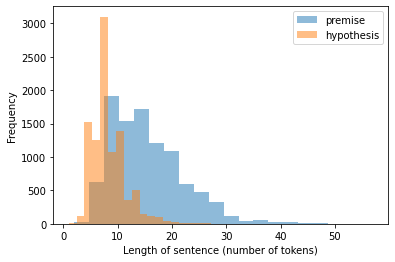

In [17]:
ax = df["len_p"].plot.hist(bins=20, alpha=0.5, label="premise")
df["len_h"].plot.hist(ax=ax, bins=20, alpha=0.5, label="hypothesis")
ax.legend()
ax.set_xlabel("Length of sentence (number of tokens)")

Text(0, 0.5, 'Length of hypothesis')

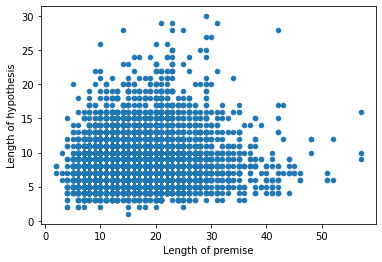

In [18]:
ax=df.plot.scatter(x="len_p", y="len_h")
ax.set_xlabel("Length of premise")
ax.set_ylabel("Length of hypothesis")

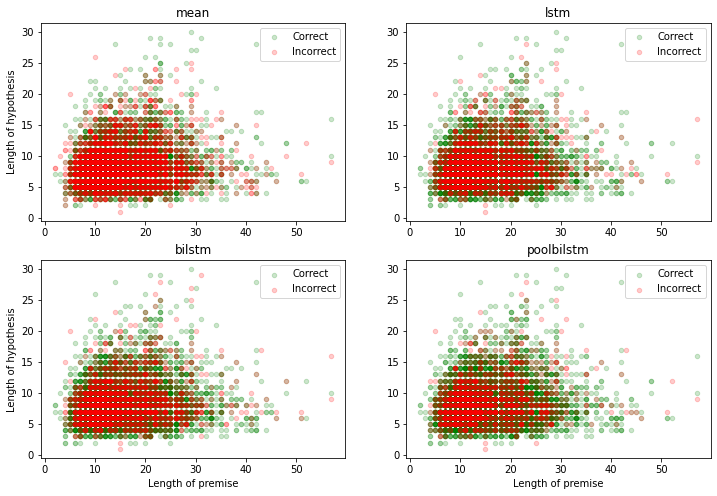

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(12,8))
for i, enc in enumerate(ENCODER_TYPES):
    ax = axs[i // 2][i % 2]
    df[df["c_"+enc] == 1].plot.scatter(ax=ax, x="len_p", y="len_h", label="Correct", color='g', alpha=0.2)
    df[df["c_"+enc] == 0].plot.scatter(ax=ax, x="len_p", y="len_h", label="Incorrect", color='r', alpha=0.2)

    if i // 2 == 1: 
        ax.set_xlabel("Length of premise")
    else:
        ax.set_xlabel(None)
    if i % 2 == 0: 
        ax.set_ylabel("Length of hypothesis")
    else:
        ax.set_ylabel(None)
    ax.set_title(enc)

In [20]:
def length_category(x):
    if x<40:
        return x // 8
    else:
        return 5
    
df["len_p_cat"] = df["len_p"].apply(length_category)
df["len_h_cat"] = df["len_h"].apply(length_category)


In [21]:
df_lenp = df[["len_p_cat", "len_p", "c_mean", "c_lstm", "c_bilstm", "c_poolbilstm"]].groupby("len_p_cat", as_index=False).mean()
df_lenh = df[["len_h_cat", "len_h", "c_mean", "c_lstm", "c_bilstm", "c_poolbilstm"]].groupby("len_h_cat", as_index=False).mean()

In [22]:
df_lenp = df[["premise", "len_p_cat", "len_p", "c_mean", "c_lstm", "c_bilstm", "c_poolbilstm"]] \
    .groupby("len_p_cat", as_index=False) \
    .agg({'premise':'count', 'len_p':'mean', 'c_mean':'mean', 'c_lstm':'mean', 'c_bilstm':'mean', 'c_poolbilstm':'mean'}) 


In [23]:
df_lenp

,len_p_cat,premise,len_p,c_mean,c_lstm,c_bilstm,c_poolbilstm
0,0,648,6.334877,0.635802,0.797840,0.799383,0.825617
1,1,5173,11.414073,0.658032,0.795090,0.803789,0.841678
2,2,2902,19.187112,0.654032,0.771192,0.784287,0.843901
3,3,887,26.569335,0.616685,0.757610,0.760992,0.815107
4,4,152,34.546053,0.651316,0.802632,0.815789,0.881579
5,5,62,43.870968,0.612903,0.774194,0.709677,0.790323


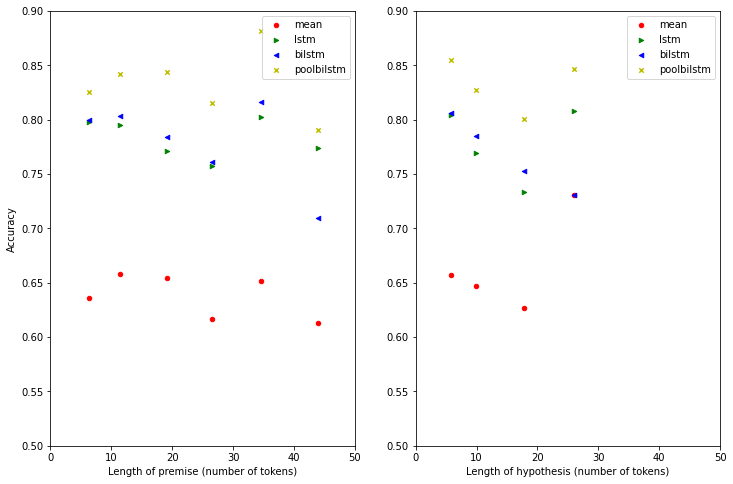

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12,8))
ax1 = axs[0]
ax1 = df_lenp.plot.scatter(x="len_p", y="c_mean", label="mean", color='r', ax=ax1)
df_lenp.plot.scatter(x="len_p", y="c_lstm", label="lstm", color='g', marker='>', ax=ax1)
df_lenp.plot.scatter(x="len_p", y="c_bilstm", label="bilstm", color='b', marker='<', ax=ax1)
df_lenp.plot.scatter(x="len_p", y="c_poolbilstm", label="poolbilstm", color='y', marker = 'x', ax=ax1)
ax1.set_ylabel("Accuracy")
ax1.set_ylim(0.5, 0.9)
ax1.set_xlabel("Length of premise (number of tokens)")
ax1.set_xlim(0,50)
ax1.legend()

ax2 =axs[1]
df_lenh.plot.scatter(x="len_h", y="c_mean", label="mean", color='r', ax=ax2)
df_lenh.plot.scatter(x="len_h", y="c_lstm", label="lstm", color='g', marker='>', ax=ax2)
df_lenh.plot.scatter(x="len_h", y="c_bilstm", label="bilstm", color='b', marker='<', ax=ax2)
df_lenh.plot.scatter(x="len_h", y="c_poolbilstm", label="poolbilstm", color='y', marker='x', ax=ax2)
ax2.set_ylabel(None)
ax2.set_ylim(0.5, 0.9)
ax2.set_xlabel("Length of hypothesis (number of tokens)")
ax2.set_xlim(0,50)
ax2.legend()

## 4.3 Test role of negations in premise and hypothesis

In [25]:
examples = [
    "He is not happy",
    "He isn't coming to the party",
    "The game wasn't over yet",
    "They don't like soccer",
    "He doesn't want to hear the noise",
    "The king didn't do justice",
    "He has no clue",
    "He hasn't done that before",
    "They hadn't gone to that party without a present",
    "He won't do that again",
    "The sun wouldn't shine for days",
    "The judge shouldn't lie"
]

In [28]:
NEGATIONS=set([
    'not', "n't", "no", "none", "never", "nobody", "nothing", "nowhere", "neither", 
    "hardly", "barely", "scarcely"
])

def has_negation(s):
    """
        s should be a list of tokens
    """
    return (NEGATIONS - set(s)) != NEGATIONS

In [29]:
df_neg = df.assign(neg=lambda x: (has_negation(x["premise"]) | has_negation(x["hypothesis"])))

In [30]:
# view some examples with negations
df_neg[["premise", "hypothesis", "label", "neg"]][df_neg["neg"] == True][:10]

,premise,hypothesis,label,neg
